# Rent prices and society in the Netherlands

This notebook contains the analysis part of our Data Madness project for Data Analysis course at DKE. It concerns rent prices of housing in Maastricht, both from a simply predictive inference angle (can we predict rental price of an apartment?) as well as from a social angle (is there a bias in price towards age? migration background?).

## Note on execution

To execute the conformal prediction part of this notebook, it is necessary to have our `madness` package in the same directory as the notebook. It is available on GitLab [under this link](https://gitlab.com/k-cybulski/dke-data-madness-2021). This package includes our implementations of conformal predictors. 

## Data sources

The data used in this notebook comes from a combination of three sources:
 - Rental advertisements for housing in Maastricht from [Pararius](https://www.pararius.com). [Scraping code](https://gitlab.com/k-cybulski/dke-data-madness-2021/-/blob/master/madness/pararius/spiders/pararius.py)
 - Rental advertisements for housing in Maastricht from [Funda](https://www.funda.nl/). [Scraping code](https://gitlab.com/k-cybulski/dke-data-madness-2021/-/blob/master/madness/pararius/spiders/funda.py)
 - [Kerncijfers per postcode (PC4) from CBS](https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/gegevens-per-postcode) for 2020. In particular, we used [this link](https://download.cbs.nl/postcode/CBS-PC4-2020-v1.zip).

We wrote the scrapers for the first two websites on our own, and proceeded to join them with the CBS PC4 postcode statistics. Notably, the CBS data for 2020 is only available for free for the four digit part of the postcode, rather than the full one. The combination of these datasets was performed in [this notebook](https://gitlab.com/k-cybulski/dke-data-madness-2021/-/blob/master/join_data.ipynb). The scraping was done in March 2021.

## Ethics

Before proceeding with the project, we evaluated the terms and conditions of the housing services we scraped to ensure we were sticking to them.

### Scraping of Pararius
[Terms and conditions](https://www.pararius.nl/info/algemene-voorwaarden) of Pararius:
> 4.3 Op de via de Website beschikbare data, en op het Woningaanbod in bijzonder, rust het databankenrecht van Pararius. Dit houdt onder meer in dat het niemand is toegestaan een substantieel gedeelte van het Woningaanbod op te vragen en te hergebruiken en/of niet-substantiële delen van het Woningaanbod herhaald en systematisch op te vragen en te hergebruiken in de zin van de Databankenwet, tenzij aan de uitzondering voor persoonlijk gebruik is voldaan (wat nooit het geval is bij commercieel hergebruik en/of opvragen).

Translated into English via [DeepL](https://www.deepl.com):
> 4.3 The data available via the Website, and in particular the Housing Conditions, are subject to Pararius' database right. This means, amongst other things, that nobody is permitted to request and reuse a substantial part of the Housing Supply and/or to request and reuse non-substantial parts of the Housing Supply repeatedly and systematically within the meaning of the Databases Act, unless the exception for personal use has been met (which is never the case with commercial reuse and/or request).

Now we note the section of the [Databankenwet](https://wetten.overheid.nl/BWBR0010591/2018-10-11) which defines the personal use criteria:
>Artikel 5.
>
>    1. De rechtmatige gebruiker van een databank die op enigerlei wijze aan het publiek ter beschikking is gesteld mag zonder toestemming van de producent van de databank een substantieel deel van de inhoud van de databank:
>
>        a. opvragen voor privé doeleinden, mits het een niet-elektronische databank betreft;
>
>        b. opvragen ter illustratie bij onderwijs of voor wetenschappelijk onderzoek, met bronvermelding en voor zover door het niet-commerciële doel gerechtvaardigd;
>
>        c. opvragen of hergebruiken voor de openbare veiligheid of in het kader van een administratieve of rechterlijke procedure.

Translated into English via DeepL:
> Article 5.
>
>    1. The lawful user of a database made available to the public in any way may, without the permission of the producer of the database, make a substantial part of the contents of the database:
>
>        a. extract it for private purposes, provided that it is a non-electronic database;
>
>        b. Extract for the purpose of illustration in teaching or scientific research, quoting the source and to the extent justified by the non-commercial purpose;
>
>        c. retrieval or reuse for public safety or in the context of administrative or judicial proceedings.

Since this project is noncommercial and solely for the purpose of education, we believe it falls under article 5.1.b of the Databankenwet shown above.

### Scraping of Funda
[Terms and conditions](https://www.funda.nl/gebruiksvoorwaarden/) of Funda:
> Het is u slechts toegestaan om één kopie van het op de website ter beschikking gestelde materiaal te downloaden voor eigen, niet-commercieel gebruik. Het is u niet toegestaan om zonder voorafgaande schriftelijke toestemming van Funda, het beschikbaar gestelde materiaal anderszins te kopiëren, te wijzigen, te distribueren, te verspreiden, te "reverse engineeren", te decompileren of op andere wijze te gebruiken en/of te exploiteren.

Translated into English via DeepL:
> You are only permitted to download one copy of the material made available on the website for your own non-commercial use. You are not allowed, without prior written permission of Funda, to otherwise copy, modify, distribute, disseminate, reverse engineer, decompile or otherwise use and/or exploit the material made available.

Since we only download material available on the website for our own noncommercial use, and do not distribute it further, we believe our work sticks to the terms and conditions.

### Ethics of analysis

Our analysis concerns the price of housing in the city of Maastricht. In the predictive part, we specifically develop models to predict prices of housing. Such models could be of interest to various stakeholder groups:
 - Tenants who wish to check if their rent is fair or, at least, standard to Maastricht housing.
 - Real estate owners who wish to rent out their housing and, for that purpose, want to know the state of the market.

For both groups, our analysis could be biased by the use of outdated data. If we were to use data from a few years ago, inflation on its own would lead to bias in model predictions. As such, we chose to use most recent data available, directly from housing websites. 

## Data loading

First, we will open the data.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score

from madness.conformal import ConformalResidualRegressor, ConformalizedQuantileRegressor


#pd.set_option('display.max_rows', None)

#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [2]:
gdf = gpd.read_file('join.shp')

In [3]:
gdf.head()

URL  \
0  https://www.pararius.com/apartment-for-rent/ma...   
1  https://www.pararius.com/apartment-for-rent/ma...   
2  https://www.pararius.com/apartment-for-rent/ma...   
3  https://www.pararius.com/house-for-rent/maastr...   
4  https://www.pararius.com/apartment-for-rent/ma...   

                                                Name   Price  \
0  For rent: Apartment Touwslagersdreef in Maastr...   995.0   
1  For rent: Apartment Wolkammersdreef 65 D in Ma...   900.0   
2  For rent: Apartment Koperslagersdreef 33 B in ...   975.0   
3       For rent: House Schippersdreef in Maastricht  1250.0   
4  For rent: Apartment Wolkammersdreef in Maastricht   950.0   

              Address  Area (Squa       Type  Number of  Year of Co  \
0  6216 PZ Maastricht        85.0  Apartment        3.0      1960.0   
1  6216 RN Maastricht        78.0  Apartment        4.0      1964.0   
2  6216 SN Maastricht        80.0  Apartment        3.0      1968.0   
3  6216 TH Maastricht        87.0      House        6.0      1965.0   
4  6216 RM Maastricht        80.0  Apartment        4.0         NaN   

   Number o_1  Number o_2  ... WON_MRGEZ  P_KOOPWON  P_HUURWON  WON_HCORP  \
0         2.0         NaN  ...    1830.0       50.0       50.0     1255.0   
1         2.0         NaN  ...    1830.0       50.0       50.0     1255.0   
2         2.0         1.0  ...    1830.0       50.0       50.0     1255.0   
3         4.0         1.0  ...    1830.0       50.0       50.0     1255.0   
4         2.0         NaN  ...    1830.0       50.0       50.0     1255.0   

   WON_NBEW  WOZWONING  UITKMINAOW     OAD  STED  \
0     135.0      180.0       800.0  2556.0   1.0   
1     135.0      180.0       800.0  2556.0   1.0   
2     135.0      180.0       800.0  2556.0   1.0   
3     135.0      180.0       800.0  2556.0   1.0   
4     135.0      180.0       800.0  2556.0   1.0   

                                            geometry  
0  POLYGON ((173187.901 318792.867, 173189.093 31...  
1  POLYGON ((173187.901 318792.867, 173189.093 31...  
2  POLYGON ((173187.901 318792.867, 173189.093 31...  
3  POLYGON ((173187.901 318792.867, 173189.093 31...  
4  POLYGON ((173187.901 318792.867, 173189.093 31...  

[5 rows x 47 columns]

In [4]:
# Unfortunately, shape files have a 10 char column name limit. We need to rename the columns.
rights=['URL', 'Name', 'Price', 'Address', 'Area (Square metre)', 'Type',
        'Number of Rooms', 'Year of Construction', 'Number of Bedrooms',
        'Number of Bathrooms', 'PC4', 'INWONER', 'MAN', 'VROUW', 'INW_014',
        'INW_1524', 'INW_2544', 'INW_4564', 'INW_65PL', 'P_NL_ACHTG',
        'P_WE_MIG_A', 'P_NW_MIG_A', 'AANTAL_HH', 'TOTHH_EENP', 'TOTHH_MPZK',
        'HH_EENOUD', 'HH_TWEEOUD', 'GEM_HH_GR', 'WONING', 'WONVOOR45',
        'WON_4564', 'WON_6574', 'WON_7584', 'WON_8594', 'WON_9504', 'WON_0514',
        'WON_1524', 'WON_MRGEZ', 'P_KOOPWON', 'P_HUURWON', 'WON_HCORP',
        'WON_NBEW', 'WOZWONING', 'UITKMINAOW', 'OAD', 'STED', 'geometry']
wrongs= gdf.columns
dic = {wrong: right for wrong, right in zip(wrongs,rights)}

In [5]:
gdf=gdf.rename(columns=dic)

## Cleaning data & Exploratory data analysis

Now, we will inspect the individual features, clean them and decide which ones might be worth including in our model.

The features we have are the following (**bold** marks features included in the EDA):

1. The data which is available for each apartment on funda and pararius:

    - **Price**: monthly rent of housing offer
    - Address
    - **Area (Square metre)**: Area in sqm
    - **Type**: Type of apartment (apartment, house, room, etc.)
    - **Number of Rooms**
    - **Year of Construction**
    - **Number of Bedrooms**
    - **Number of Bathrooms**
    - **PC4**: 4 digit zip code (extracted from Address)
    

2. Data from CBS statistics, each feature describes the area represented by the first 4 digits of the zip codes

    - INWONER: number of residents in area
    - MAN: number of men
    - VROUW: number of women
    - **INW_014**: number of residents between 0 and 14
    - **INW_1524**:: number of residents between 15 and 24
    - **INW_2544**: number of residents between 25 and 44
    - **INW_4564**: number of residents between 45 and 64
    - **INW_65PL**: number of residents above 65
    - **P_NL_ACHTG**: percentage of residents with Dutch background
    - **P_WE_MIG_A**: percentage of residents with western migration background
    - **P_NW_MIG_A**: percentage of residents with non-western migration background
    - AANTAL_HH: number of households
    - TOTHH_EENP: number of one person households
    - TOTHH_MPZK: number of several person households
    - HH_EENOUD: number of households with single parents
    - HH_TWEEOUD: number of households with two parents
    - GEM_HH_GR: average household size
    - WONING: number of houses/apartments (not exactly sure what is meant here and what is the difference to households due to missing Dutch skills)
    - WONVOOR45: house/apartment built before 1945
    - WON_4564: house/apartment built between XX and XX
    - WON_6574
    - WON_7584
    - WON_8594
    - WON_9504
    - WON_0514
    - WON_1524
    - WON_MRGEZ: number of apartment buildings
    - P_KOOPWON: percentage of houses/apartments owned by their inhabitants
    - P_HUURWON: percentage of rented houses/ apartments
    - WON_HCORP: number of apartments owned by housing corporations
    - WON_NBEW: number of empty houses/ flats
    - WOZWONING: average property valuation value
    - UITKMINAOW: number of social benefit recipients
    - OAD: density of addresses
    - STED: urbanisation

## Exploratory data analysis

### Price

The feature Price indicates the monthly rent of the apartment and will be our target variable.

In [6]:
gdf['Price'].describe()

count     546.000000
mean      941.917582
std       590.113246
min        31.000000
25%       475.000000
50%       812.500000
75%      1230.000000
max      4950.000000
Name: Price, dtype: float64

In [7]:
gdf['Price'].median()

812.5

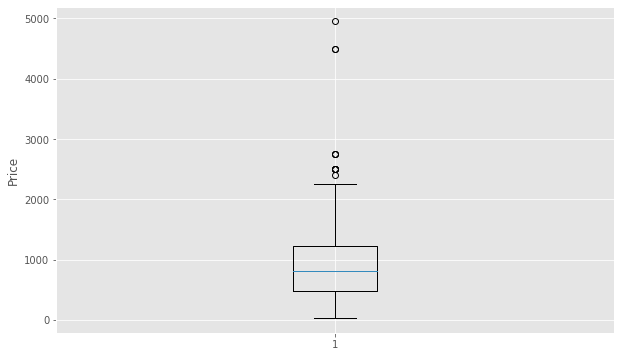

In [8]:
plt.boxplot(gdf['Price'])
plt.ylabel("Price")
plt.show()

From the box plot and the descriptives, we can see that there are some very low and some very high values for 'Price'. We will need to investigate why there are such extreme values.

First, let's have a look at the very low values.

In [9]:
gdf[gdf['Price']<350]

URL  \
8    https://www.funda.nl//huur/maastricht/parkeerg...   
21   https://www.pararius.com/room-for-rent/maastri...   
116  https://www.pararius.com/house-for-rent/maastr...   
120  https://www.pararius.com/room-for-rent/maastri...   
124  https://www.pararius.com/room-for-rent/maastri...   
157  https://www.pararius.com/room-for-rent/maastri...   
161  https://www.pararius.com/apartment-for-rent/ma...   
168  https://www.pararius.com/room-for-rent/maastri...   
172  https://www.pararius.com/room-for-rent/maastri...   
173  https://www.pararius.com/room-for-rent/maastri...   
175  https://www.pararius.com/room-for-rent/maastri...   
179  https://www.funda.nl//huur/maastricht/parkeerg...   
196  https://www.pararius.com/room-for-rent/maastri...   
201  https://www.pararius.com/room-for-rent/maastri...   
208  https://www.pararius.com/room-for-rent/maastri...   
264  https://www.pararius.com/room-for-rent/maastri...   
302  https://www.pararius.com/room-for-rent/maastri...   
349  https://www.pararius.com/room-for-rent/maastri...   
365  https://www.pararius.com/room-for-rent/maastri...   
377  https://www.funda.nl//huur/maastricht/parkeerg...   
448  https://www.funda.nl//huur/maastricht/parkeerg...   
465  https://www.pararius.com/room-for-rent/maastri...   
476  https://www.pararius.com/room-for-rent/maastri...   
484  https://www.pararius.com/room-for-rent/maastri...   
522  https://www.pararius.com/room-for-rent/maastri...   

                                                  Name  Price  \
8                            Brusselse Poort garagebox  115.0   
21    For rent: Room Wycker Grachtstraat in Maastricht  230.0   
116  For rent: House Wycker Grachtstraat in Maastricht  295.0   
120            For rent: Room Bloemenweg in Maastricht  319.0   
124   For rent: Room Wycker Grachtstraat in Maastricht  337.0   
157           For rent: Room Oranjeplein in Maastricht  310.0   
161  For rent: Apartment Kolonel Millerstraat in Ma...  285.0   
168  For rent: Room Koning Clovisstraat 60 B3 in Ma...  290.0   
172           For rent: Room Prinsenlaan in Maastricht  275.0   
173            For rent: Room Heerderweg in Maastricht  223.0   
175           For rent: Room Eburonenweg in Maastricht  240.0   
179                               Dokter Nevenstraat 1   60.0   
196          For rent: Room Orleansplein in Maastricht  290.0   
201           For rent: Room Condéstraat in Maastricht  270.0   
208          For rent: Room Orleansplein in Maastricht  305.0   
264           For rent: Room Tongerseweg in Maastricht  325.0   
302          For rent: Room Hertogsingel in Maastricht  263.0   
349        For rent: Room Calvariestraat in Maastricht  300.0   
365          For rent: Room Hertogsingel in Maastricht  300.0   
377                                         Bassin 186  121.0   
448                                     Atletenbaan 70   31.0   
465  For rent: Room Burgemeester Cortenstraat 49 B ...  310.0   
476          For rent: Room Bergerstraat in Maastricht  310.0   
484          For rent: Room Bergerstraat in Maastricht  337.0   
522        For rent: Room Heugemerstraat in Maastricht  347.0   

                Address  Area (Square metre)       Type  Number of Rooms  \
8    6216 CT Maastricht                  NaN       None              NaN   
21   6221 CT Maastricht                 15.0       Room              1.0   
116  6221 CW Maastricht                 12.0      House              2.0   
120  6221 TW Maastricht                  8.0       Room              1.0   
124  6221 CX Maastricht                 11.0       Room              1.0   
157  6224 KP Maastricht                 10.0       Room              1.0   
161  6224 XN Maastricht                 25.0  Apartment              1.0   
168  6224 GZ Maastricht                 13.0       Room              1.0   
172  6224 LR Maastricht                  6.0       Room              1.0   
173  6224 LE Maastricht                  7.0       Room              1.0   
175  6224 HX Ma

Some of the instances with very low prices seem to be parking spots or garages. Since we're interested in apartments and rooms, we will discard these entries.

In [10]:
gdf=gdf.drop([448, 337, 179, 8, 377])

Now, let's have a look at the very high prices.

In [11]:
gdf[gdf['Price']>2200]

URL  \
68   https://www.pararius.com/apartment-for-rent/ma...   
79   https://www.pararius.com/apartment-for-rent/ma...   
92   https://www.pararius.com/house-for-rent/maastr...   
93   https://www.pararius.com/apartment-for-rent/ma...   
126  https://www.pararius.com/apartment-for-rent/ma...   
216  https://www.pararius.com/apartment-for-rent/ma...   
220  https://www.pararius.com/house-for-rent/maastr...   
226  https://www.pararius.com/apartment-for-rent/ma...   
249  https://www.pararius.com/apartment-for-rent/ma...   
254  https://www.pararius.com/apartment-for-rent/ma...   
269  https://www.pararius.com/house-for-rent/maastr...   
282  https://www.pararius.com/house-for-rent/maastr...   
309  https://www.pararius.com/apartment-for-rent/ma...   
343  https://www.pararius.com/house-for-rent/maastr...   
441  https://www.pararius.com/house-for-rent/maastr...   
446  https://www.pararius.com/house-for-rent/maastr...   
456  https://www.pararius.com/house-for-rent/maastr...   
458  https://www.pararius.com/house-for-rent/maastr...   
541  https://www.funda.nl//huur/maastricht/appartem...   

                                                  Name   Price  \
68      For rent: Apartment Levignelunet in Maastricht  2250.0   
79       For rent: Apartment Stellalunet in Maastricht  2500.0   
92   For rent: House Wycker Grachtstraat in Maastricht  2750.0   
93       For rent: Apartment Stellalunet in Maastricht  2500.0   
126       For rent: Apartment Plein 1992 in Maastricht  4500.0   
216    For rent: Apartment Hoenderstraat in Maastricht  2250.0   
220  For rent: House Henric van Veldekeplein in Maa...  2250.0   
226  For rent: Apartment Uitbelderstraat in Maastricht  2495.0   
249  For rent: Apartment Uitbelderstraat in Maastricht  2500.0   
254        For rent: Apartment De Cassij in Maastricht  2750.0   
269  For rent: House Prins Hessen Casselstraat in M...  2400.0   
282     For rent: House Herdenkingsplein in Maastricht  2250.0   
309  For rent: Apartment Polvertorenstraat in Maast...  2250.0   
343      For rent: House Uitbelderstraat in Maastricht  2250.0   
441           For rent: House Klinkhegge in Maastricht  2500.0   
446         For rent: House Karposthegge in Maastricht  2250.0   
456   For rent: House Henri Goovaertsweg in Maastricht  4500.0   
458            For rent: House Luikerweg in Maastricht  4950.0   
541         De Merodelaan 70 Bus 4 3620 Lanaken BELGIË  2750.0   

                Address  Area (Square metre)                       Type  \
68   6221 KM Maastricht                107.0                  Apartment   
79   6221 JG Maastricht                174.0                  Apartment   
92   6221 CW Maastricht                220.0                      House   
93   6221 JG Maastricht                210.0                  Apartment   
126  6221 JP Maastricht                154.0                  Apartment   
216  6211 EL Maastricht                139.0                  Apartment   
220  6211 TG Maastricht                190.0                      House   
226  6211 SL Maastricht                125.0                  Apartment   
249  6211 SL Maastricht                100.0                  Apartment   
254  6211 WE Maastricht                160.0                  Apartment   
269  6211 JZ Maastricht                120.0                      House   
282  6211 PX Maastricht                165.0                      House   
309  6211 LX Maastricht                115.0                  Apartment   
343  6211 SL Maastricht                155.0                      House   
441  6225 KG Maastricht                141.0                      House   
446  6225 KJ Maastricht                170.0                      House   
456  6212 BW Maastricht                308.0                      House   
458  6212 ET Maastricht                288.0                      House   
541     6218 Maastricht                275.0  Portiekflat (appartement)   

     Number of Rooms  Year of Construction  Number of Bedrooms  \
68

We will keep these apartments, since they just seem to be very big/ luxurious apartments. However, some of the apartments actually seem to be in Belgium, not in Maastricht. We will discard these entries.

In [12]:
gdf[gdf['Name'].apply(lambda x: 'BELGIË' in x)]

URL  \
540  https://www.funda.nl//huur/maastricht/huis-419...   
541  https://www.funda.nl//huur/maastricht/appartem...   

                                           Name   Price          Address  \
540             Waterstraat 47, Lanaken, BELGIË  1890.0  6218 Maastricht   
541  De Merodelaan 70 Bus 4 3620 Lanaken BELGIË  2750.0  6218 Maastricht   

     Area (Square metre)                               Type  Number of Rooms  \
540                215.0  Woonboerderij, vrijstaande woning              2.0   
541                275.0          Portiekflat (appartement)              4.0   

     Year of Construction  Number of Bedrooms  Number of Bathrooms  ...  \
540                1850.0                 1.0                  1.0  ...   
541                1990.0                 3.0                  2.0  ...   

    WON_MRGEZ  P_KOOPWON  P_HUURWON  WON_HCORP  WON_NBEW  WOZWONING  \
540    1305.0       40.0       60.0     2080.0     110.0      183.0   
541    1305.0       40.0       60.0     2080.0     110.0      183.0   

     UITKMINAOW     OAD  STED  \
540       940.0  1736.0   2.0   
541       940.0  1736.0   2.0   

                                              geometry  
540  MULTIPOLYGON (((174263.948 318854.557, 174253....  
541  MULTIPOLYGON (((174263.948 318854.557, 174253....  

[2 rows x 47 columns]

In [13]:
gdf=gdf.drop([540, 541])

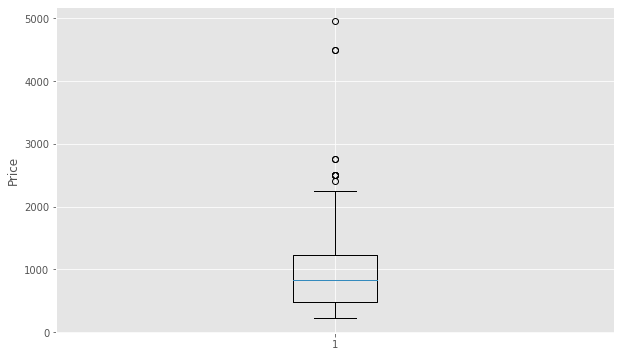

In [14]:
plt.boxplot(gdf['Price'])
plt.ylabel("Price")
plt.show()

Another thing that might be interestin to investigate is spatial distribution of the price. In the CBS data, there are polygons representing each 4 digit zip code area in Maastricht. We will use these to plot the price per square meter per 4 digit zip code.

In [15]:
# establish column with price per sqm
gdf['Price/sqm']= gdf['Price']/gdf['Area (Square metre)']

In [16]:
# compute mean price per sqm for each 4 digit zip code and put this information into geodataframe
prc_area = gpd.GeoDataFrame(gdf['Price/sqm'].groupby(gdf['PC4']).mean())

In [17]:
prc_area['PC4']= prc_area.index

In [18]:
lst=list(gdf['PC4'].unique())

In [19]:
# map zip codes to geometries
dct= {}
for x in lst:
    dct[x]= gdf.loc[gdf['PC4'] == x].iloc[0]['geometry']

In [20]:
# establish column with geometries
prc_area['geometry'] = prc_area['PC4'].apply(lambda x: dct[x])

In [21]:
prc_area.head()

Price/sqm   PC4                                           geometry
PC4                                                                     
6211  22.403829  6211  MULTIPOLYGON (((176168.871 316818.943, 176166....
6212  16.893743  6212  POLYGON ((176064.228 316935.378, 176065.839 31...
6213  22.653595  6213  POLYGON ((175699.824 317220.367, 175700.648 31...
6214  20.119915  6214  POLYGON ((175431.728 317745.106, 175434.855 31...
6215  13.405192  6215  POLYGON ((173091.667 317548.138, 173096.388 31...

In [22]:
prc_area = prc_area.set_crs(epsg=28992)
gdf = gdf.set_crs(epsg=28992)

In [23]:
import folium

In [24]:
# map price per sqm per 4 digit zip code area
m = folium.Map(location=[50.851368, 5.690973], zoom_start=10)
folium.Choropleth(
    geo_data=prc_area['geometry'],
    name="choropleth",
    data=prc_area,
    columns=["PC4","Price/sqm"],
    key_on='feature.id',
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=.1,
    legend_name="Price/sqm",
    reset=True,
).add_to(m)
m

What we can observe from the map is that the centre of Maastricht seems to be the most expensive, apart from one area North to the centre. This area is mostly industrial but has a small fancy area with apartment next to a port. The outskirts are more cheap in comparison.

### Area (Square metre)

In [25]:
gdf['Area (Square metre)'].describe()

count    538.000000
mean      54.923792
std       44.332582
min        6.000000
25%       20.000000
50%       41.500000
75%       80.000000
max      308.000000
Name: Area (Square metre), dtype: float64

In [26]:
gdf['Area (Square metre)'].median()

41.5

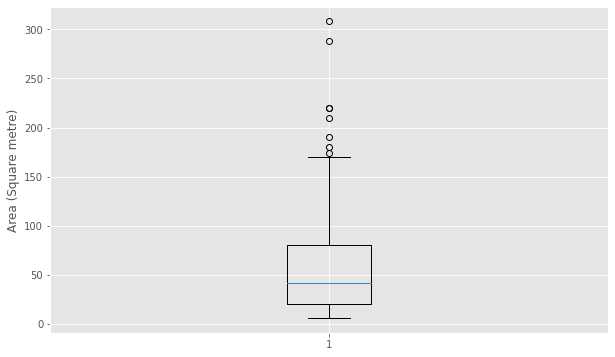

In [27]:
plt.boxplot(gdf['Area (Square metre)'].dropna())
plt.ylabel("Area (Square metre)")
plt.show()

## Type

<AxesSubplot:>

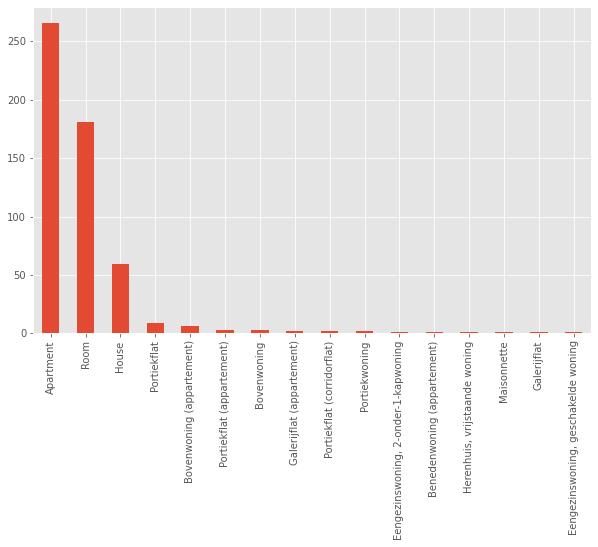

In [28]:
typ= gdf['Type'].value_counts()
typ.plot.bar()

There are a lot of different apartment and house types with very little instances. I will sort them into three main categories: Apartment, house, room. We will count row houses as houses, not apartments.

In [29]:
gdf['Type'].unique()

array(['Apartment', 'House', 'Room', 'Portiekflat (appartement)',
       'Maisonnette', 'Portiekwoning', 'Bovenwoning', 'Portiekflat',
       'Bovenwoning (appartement)', 'Galerijflat (appartement)',
       'Galerijflat', 'Portiekflat (corridorflat)',
       'Benedenwoning (appartement)',
       'Eengezinswoning, 2-onder-1-kapwoning',
       'Herenhuis, vrijstaande woning',
       'Eengezinswoning, geschakelde woning'], dtype=object)

In [30]:
# sort each type of house into one of the three categories
def housing_type(string):
    apartements = ['Apartment', 'Portiekflat', 'Maisonnette', 'Portiekwoning', 'Bovenwoning', 'Galerijflat', 'appartement']
    houses = ['House', 'Eengezinswoning', 'Herenhuis']
    rooms = ['Room']
    try:
        if any(apartement in string for apartement in apartements):
            return 'Apartment'
        if any(house in string for house in houses):
            return 'House'
        if any(room in string for room in rooms):
            return "Room"
    except:
        return 'None'

In [31]:
gdf['Type_3'] = gdf['Type'].apply(lambda x: housing_type(x))

<AxesSubplot:>

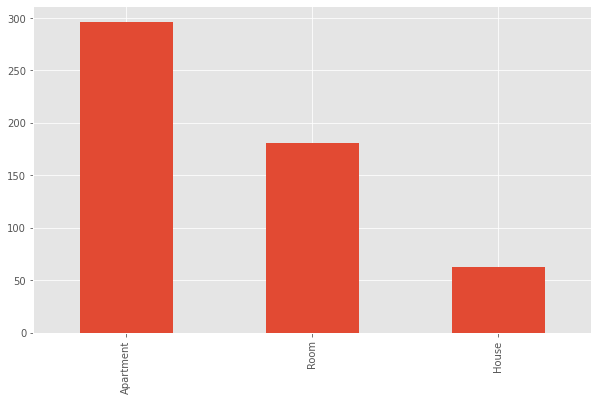

In [32]:
typ= gdf['Type_3'].value_counts()
typ.plot.bar()

We can see that most of the housing offers are apartments, followed by rooms, which is not surprising given that Maastricht is a university city, and the smallest group are houses.

### Number of Rooms

In [33]:
gdf['Number of Rooms'].value_counts().sort_index()

1.0     225
2.0     120
3.0     107
4.0      40
5.0      23
6.0       6
7.0      12
8.0       2
9.0       1
10.0      2
14.0      1
Name: Number of Rooms, dtype: int64

<AxesSubplot:>

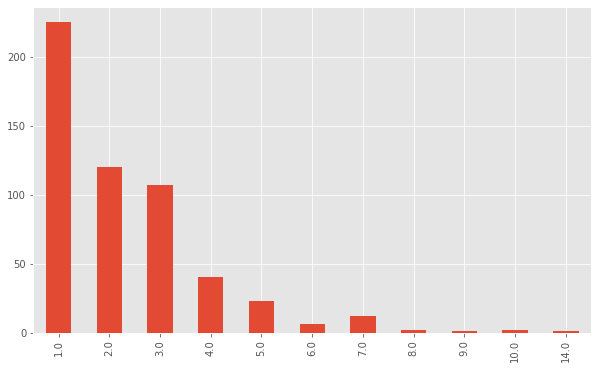

In [34]:
rooms= gdf['Number of Rooms'].value_counts().sort_index()
rooms.plot.bar()

### Year of Construction

We will map the number of houses that were built in each decade:

In [35]:
def decade(year):
    try:
        return int(year / 10) * 10
    except:
        return None
decades_considered = range(decade(gdf['Year of Construction'].min()), decade(gdf['Year of Construction'].max() + 10), 10)

<AxesSubplot:>

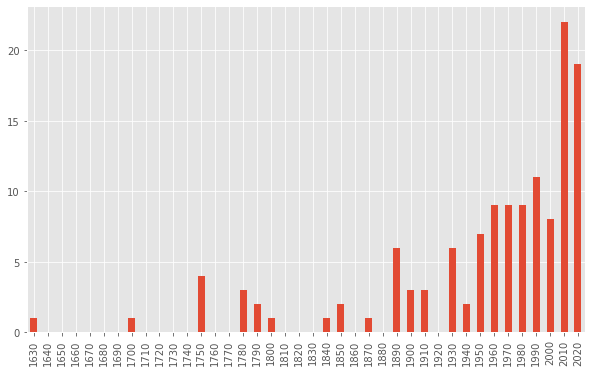

In [36]:
years= gdf['Year of Construction'].apply(decade).value_counts().reindex(decades_considered, fill_value=0).sort_index()
years.plot.bar()

We can see that most houses that are offered have been built very recently- the largest category are 2010s. Some houses, date back as far as the 1630s.

### Number of Bedrooms

In [37]:
gdf['Number of Bedrooms'].value_counts().sort_index()

1.0    167
2.0    113
3.0     26
4.0     13
5.0      1
6.0      1
Name: Number of Bedrooms, dtype: int64

<AxesSubplot:>

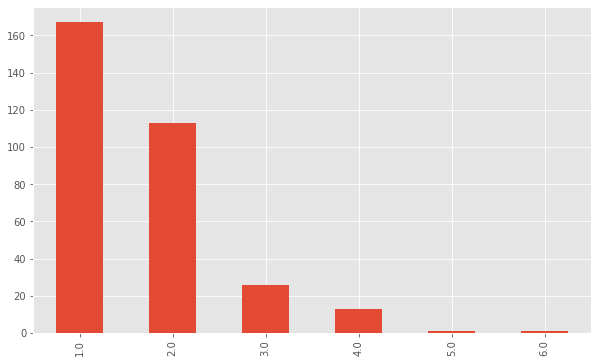

In [38]:
bedrooms= gdf['Number of Bedrooms'].value_counts().sort_index()
bedrooms.plot.bar()

### Number of Bathrooms

In [39]:
gdf['Number of Bathrooms'].value_counts().sort_index()

1.0    154
2.0     10
3.0      1
4.0      1
Name: Number of Bathrooms, dtype: int64

<AxesSubplot:>

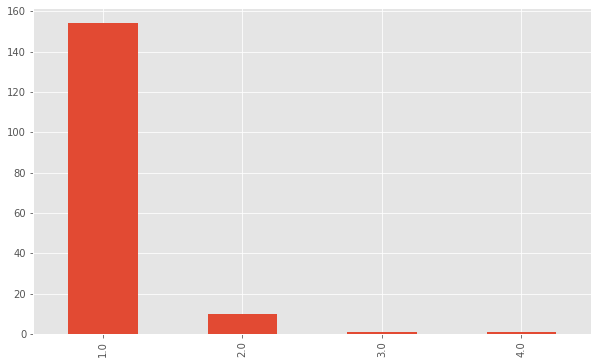

In [40]:
bathrooms= gdf['Number of Bathrooms'].value_counts().sort_index()
bathrooms.plot.bar()

### Age groups

We have the number of inhabitants for 5 different age groups: 0-14, 15-24, 25-44, 45-64, 65+.
Since the zip code areas have different sizes and population densities, the amount of inhabitants of each age group is not very informative. Instead, we will compute percentages for each age group.

In [41]:
lst = ['INW_014','INW_1524', 'INW_2544', 'INW_4564', 'INW_65PL']
for elem in lst:
    name= elem+'_pct'
    gdf[name]= gdf[elem]/gdf['INWONER']

In [42]:
inw= gdf[['INW_014','INW_1524', 'INW_2544', 'INW_4564', 'INW_65PL']]
inw.describe()

INW_014     INW_1524     INW_2544     INW_4564     INW_65PL
count   539.000000   539.000000   539.000000   539.000000   539.000000
mean    629.044527  2457.643785  2455.779221  1743.367347  1755.519481
std     218.313206  1346.357717   939.627163   342.253801   438.572275
min     170.000000   180.000000   380.000000   540.000000   395.000000
25%     425.000000  1165.000000  1625.000000  1725.000000  1525.000000
50%     640.000000  2405.000000  2745.000000  1800.000000  2060.000000
75%     690.000000  4285.000000  3540.000000  1900.000000  2075.000000
max    1175.000000  4285.000000  3540.000000  2750.000000  2295.000000

In [43]:
inw_pcts = gdf[
    ['PC4', 'INW_014_pct','INW_1524_pct', 'INW_2544_pct', 'INW_4564_pct', 'INW_65PL_pct']
              ].groupby('PC4').mean() # They're all the same value, so mean/median are all the same

In [44]:
inw_pcts.index

Index(['6211', '6212', '6213', '6214', '6215', '6216', '6217', '6218', '6219',
       '6221', '6222', '6223', '6224', '6225', '6226', '6227', '6228', '6229'],
      dtype='object', name='PC4')

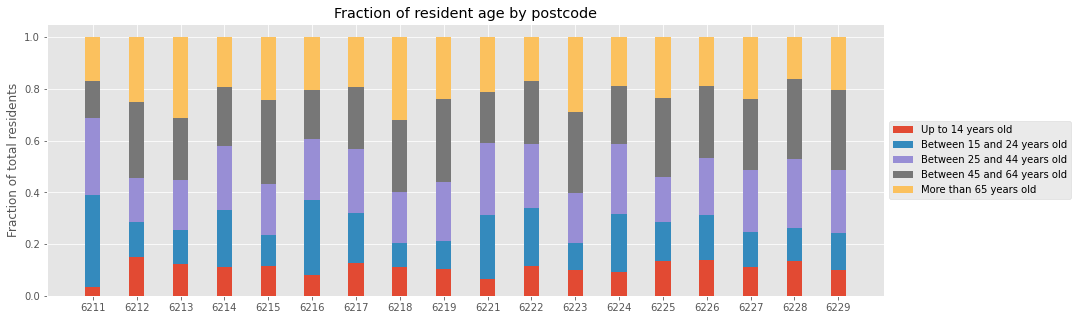

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))
width=0.35

inw_pcts_labels = [
    ('INW_014_pct', 'Up to 14 years old'),
    ('INW_1524_pct', 'Between 15 and 24 years old'),
    ('INW_2544_pct', 'Between 25 and 44 years old'),
    ('INW_4564_pct', 'Between 45 and 64 years old'),
    ('INW_65PL_pct', 'More than 65 years old'),
]

ax.bar(inw_pcts.index, inw_pcts[inw_pcts_labels[0][0]], width, label=inw_pcts_labels[0][1])
bottoms = inw_pcts[inw_pcts_labels[0][0]].copy()
for i in range(1, len(inw_pcts_labels)):
    ax.bar(inw_pcts.index, inw_pcts[inw_pcts_labels[i][0]], width, 
           label=inw_pcts_labels[i][1], 
           bottom=bottoms)
    bottoms += inw_pcts[inw_pcts_labels[i][0]]
    
ax.set_ylabel('Fraction of total residents')
ax.set_title('Fraction of resident age by postcode')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Here we can see that the age profile varies considerable per zip code area.

### Migration Background

From the CBS data we have the following information for each 4 digit zip code area regarding the ethnicity of the residents:

- P_NL_ACHTG - Percentage of residents with Dutch backrgound
- P_WE_MIG_A - Percentage of residents with western migration background
- P_NW_MIG_A - Percentage of residents with non-western migration background

Since these features might be interesting for predicting housing prices, we we should explore these.

In [46]:
mig = gdf[['P_NL_ACHTG','P_WE_MIG_A', 'P_NW_MIG_A']]

In [47]:
mig.describe()

P_NL_ACHTG  P_WE_MIG_A  P_NW_MIG_A
count  539.000000  539.000000  539.000000
mean    60.018553   28.423006   11.113173
std      8.908854    8.977414    4.209234
min     50.000000   10.000000    0.000000
25%     50.000000   20.000000   10.000000
50%     60.000000   30.000000   10.000000
75%     70.000000   40.000000   10.000000
max     90.000000   40.000000   20.000000

In [48]:
mig_pcts = gdf[
    ['PC4', 'P_NL_ACHTG','P_WE_MIG_A', 'P_NW_MIG_A']
              ].groupby('PC4').mean()

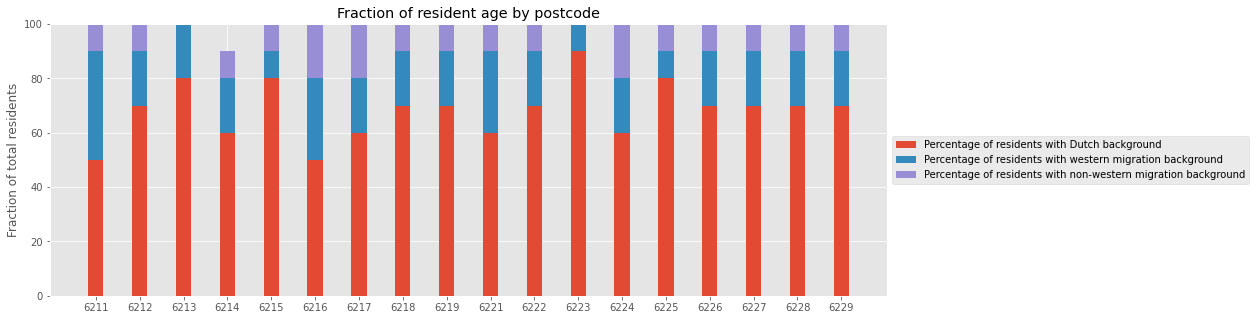

In [49]:
fig, ax = plt.subplots(figsize=(15, 5))
width=0.35

mig_pcts_labels = [
    ('P_NL_ACHTG', 'Percentage of residents with Dutch background'),
    ('P_WE_MIG_A', 'Percentage of residents with western migration background'),
    ('P_NW_MIG_A', 'Percentage of residents with non-western migration background'),
]

ax.bar(mig_pcts.index, mig_pcts[mig_pcts_labels[0][0]], width, label=mig_pcts_labels[0][1])
bottoms = mig_pcts[mig_pcts_labels[0][0]].copy()
for i in range(1, len(mig_pcts_labels)):
    ax.bar(mig_pcts.index, mig_pcts[mig_pcts_labels[i][0]], width, 
           label=mig_pcts_labels[i][1], 
           bottom=bottoms)
    bottoms += mig_pcts[mig_pcts_labels[i][0]]
    
ax.set_ylabel('Fraction of total residents')
ax.set_title('Fraction of resident age by postcode')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [50]:
mig_pcts['PC4']= mig_pcts.index

In [51]:
mig_pcts['geometry'] = mig_pcts['PC4'].apply(lambda x: dct[x])

In [52]:
mig_pcts = gpd.GeoDataFrame(mig_pcts)

In [53]:
mig_pcts = mig_pcts.set_crs(epsg=28992)

In [54]:
m_mig = folium.Map(location=[50.851368, 5.690973], zoom_start=10)
folium.Choropleth(
    geo_data=mig_pcts['geometry'],
    name="choropleth",
    data=mig_pcts,
    columns=["PC4","P_WE_MIG_A"],
    key_on='feature.id',
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=.1,
    legend_name="Percent of residents with western migration background",
    reset=True,
).add_to(m_mig)
m_mig

In [55]:
m_mig = folium.Map(location=[50.851368, 5.690973], zoom_start=10)
folium.Choropleth(
    geo_data=mig_pcts['geometry'],
    name="choropleth",
    data=mig_pcts,
    columns=["PC4","P_NW_MIG_A"],
    key_on='feature.id',
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=.1,
    legend_name="Percent of residents with non-western migration background",
    reset=True,
).add_to(m_mig)
m_mig

The first map shows the spatial distribution of immigrants with western background, the second map shows the dstribution of immigrants with non-western background. The concentration of immigrants with non-western background is highest around the center, while the concentration of immigrants with non-western background is highest in two areas adjacent to the center and one area in the west of the city.

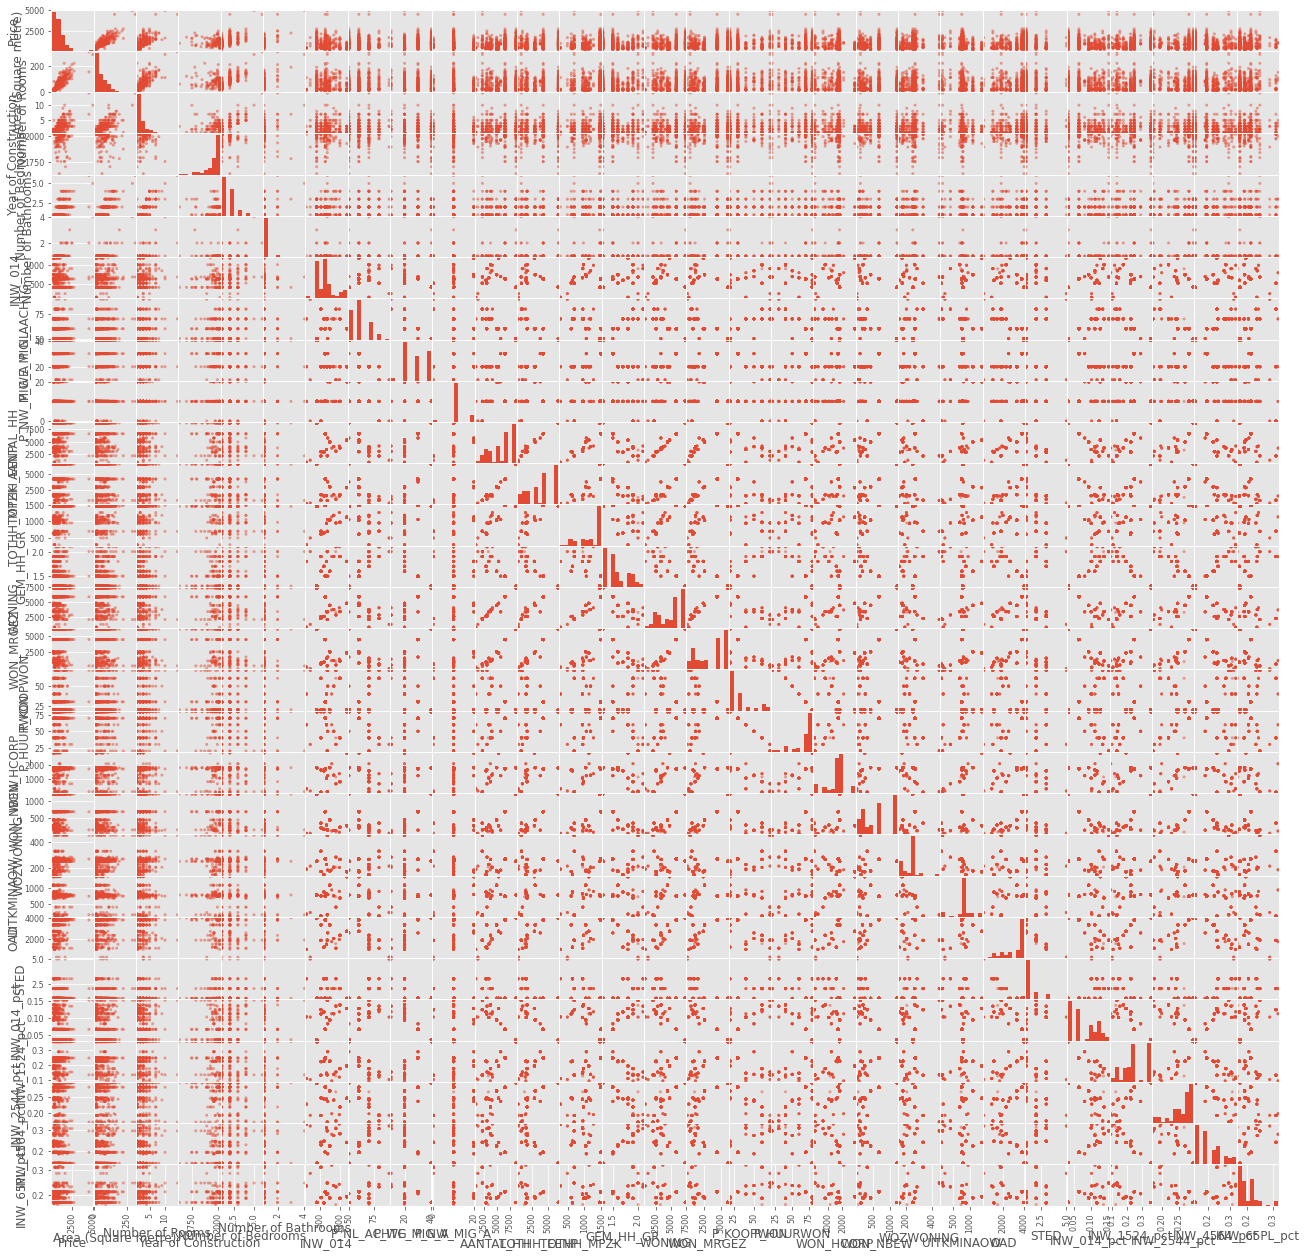

In [56]:
pd.plotting.scatter_matrix(gdf[['Price', 'Area (Square metre)',
       'Number of Rooms', 'Year of Construction', 'Number of Bedrooms',
       'Number of Bathrooms', 'INW_014','P_NL_ACHTG', 'P_WE_MIG_A', 'P_NW_MIG_A', 'AANTAL_HH', 
       'TOTHH_EENP', 'TOTHH_MPZK', 'GEM_HH_GR', 'WONING', 'WON_MRGEZ', 'P_KOOPWON', 'P_HUURWON', 'WON_HCORP',
       'WON_NBEW', 'WOZWONING', 'UITKMINAOW', 'OAD', 'STED',
       'INW_014_pct', 'INW_1524_pct', 'INW_2544_pct',
       'INW_4564_pct', 'INW_65PL_pct']], figsize=(22,22))

plt.show()


## Missing values

We will now have a look at how many missing values each feature has.

In [57]:
na=pd.DataFrame(gdf.isna().sum())
na

0
URL                     0
Name                    0
Price                   0
Address                 0
Area (Square metre)     1
Type                    0
Number of Rooms         0
Year of Construction  409
Number of Bedrooms    218
Number of Bathrooms   373
PC4                     0
INWONER                 0
MAN                     0
VROUW                   0
INW_014                 0
INW_1524                0
INW_2544                0
INW_4564                0
INW_65PL                0
P_NL_ACHTG              0
P_WE_MIG_A              0
P_NW_MIG_A              0
AANTAL_HH               0
TOTHH_EENP              0
TOTHH_MPZK              0
HH_EENOUD               0
HH_TWEEOUD              0
GEM_HH_GR               0
WONING                  0
WONVOOR45               8
WON_4564                0
WON_6574               25
WON_7584               16
WON_8594                8
WON_9504               24
WON_0514               11
WON_1524              136
WON_MRGEZ               0
P_KOOPWON               0
P_HUURWON               0
WON_HCORP               0
WON_NBEW                0
WOZWONING               0
UITKMINAOW              0
OAD                     0
STED                    0
geometry                0
Price/sqm               1
Type_3                  0
INW_014_pct             0
INW_1524_pct            0
INW_2544_pct            0
INW_4564_pct            0
INW_65PL_pct            0

In [58]:
gdf[gdf['Area (Square metre)'].isna()]

URL  \
140  https://www.funda.nl//huur/maastricht/appartem...   

                       Name   Price             Address  Area (Square metre)  \
140  Wycker Brugstraat 23 C  1045.0  6221 EA Maastricht                  NaN   

                          Type  Number of Rooms  Year of Construction  \
140  Bovenwoning (appartement)              2.0                1898.0   

     Number of Bedrooms  Number of Bathrooms  ...     OAD  STED  \
140                 NaN                  NaN  ...  3771.0   1.0   

                                              geometry  Price/sqm     Type_3  \
140  POLYGON ((177560.754 318970.986, 177557.863 31...        NaN  Apartment   

     INW_014_pct  INW_1524_pct  INW_2544_pct  INW_4564_pct  INW_65PL_pct  
140     0.065473      0.246036      0.280818      0.194373      0.213811  

[1 rows x 54 columns]

We can see that Area has one missing value. We will impute it by using the mean for that type of housing offer (Apartment).

In [59]:
gdf.iloc[140]['Area (Square metre)']= gdf['Area (Square metre)'].groupby(gdf['Type_3']).mean().Apartment

<ipython-input-59-3052fc896be1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.iloc[140]['Area (Square metre)']= gdf['Area (Square metre)'].groupby(gdf['Type_3']).mean().Apartment


In [60]:
na=pd.DataFrame(gdf.isna().sum())
na

0
URL                     0
Name                    0
Price                   0
Address                 0
Area (Square metre)     1
Type                    0
Number of Rooms         0
Year of Construction  409
Number of Bedrooms    218
Number of Bathrooms   373
PC4                     0
INWONER                 0
MAN                     0
VROUW                   0
INW_014                 0
INW_1524                0
INW_2544                0
INW_4564                0
INW_65PL                0
P_NL_ACHTG              0
P_WE_MIG_A              0
P_NW_MIG_A              0
AANTAL_HH               0
TOTHH_EENP              0
TOTHH_MPZK              0
HH_EENOUD               0
HH_TWEEOUD              0
GEM_HH_GR               0
WONING                  0
WONVOOR45               8
WON_4564                0
WON_6574               25
WON_7584               16
WON_8594                8
WON_9504               24
WON_0514               11
WON_1524              136
WON_MRGEZ               0
P_KOOPWON               0
P_HUURWON               0
WON_HCORP               0
WON_NBEW                0
WOZWONING               0
UITKMINAOW              0
OAD                     0
STED                    0
geometry                0
Price/sqm               1
Type_3                  0
INW_014_pct             0
INW_1524_pct            0
INW_2544_pct            0
INW_4564_pct            0
INW_65PL_pct            0

# Modeling

Before we proceed with the modeling part of the project, we need to address the issue of the missing values with some of our features. This is the percentage of missing values for our most problematic features:

- `Year of Construction` : 409 missing entries (This is 75.8% of all the values of the feature)
- `Number of Bathrooms` : 373 missing entries (This is 69.2% of all the values of the feature)
- `Number of Bedrooms` :  218 missing entries (This is 40.4% of all the values of the feature)


All of the above features were created after scraping the two real estate websites (Pararius and Funda). It was expected that such a problem would occur, since these fields are not mandatory and many sellers choose to not state such details if they think that it will hurt their offer in the website.

As can be observed, the above 3 features have a huge percentage of missing values. After some discussion we considered three main directions for these features:

1. Fill the missing values using the mean of the known values
2. Fill the missing values based on another feature (e.g.  `Number of Rooms` vs `Number of Bedrooms`) and by creating a simple Linear Regression model
3. Discarding the features

After some experimentation we chose to discard options 1 and 2. We observed that if we filled the missing values using the mean of the known values then this would create features that have very low variance (the vast majority of their values would be the same), which wouldn't add any important information to the model. Moreover, if we chose to fill the missing values based on another feature, then this would create a very high correlation with the other feature and therefore this approach wouldn't add any new information to our predictions. 


For all the aformentioned reasons option 3 was chosen and the features `[Year of Construction, Number of Bathrooms, Number of Bedrooms]` were discarded. 





### Preparing the dataset for Modeling and  Feature Selection/Engineering

We also need to prepare our data before we proceed with the modeling part of the project. Certain features like `URL`,  `Name` or other features from the CBS dataset will be discarded since they are not closely related with our rent prediction task. Moreover, `Price/sqm` will be deleted since it is directly created by our dependent variable `Price`.

The feature `Type_3` which is a categorical variable and represents the type of the property will be turned into two binary features:

- [1, 0]: If it is an Apartment
- [0, 1]: If it is a House
- [0, 0]: If it is a Room


Moreover, from the EDA part of the notebook we observed that zipcode plays a role to the value of a property. There are certain areas in Maastricht which have properties with much higher values than others. Therefore we thought of creating 18 different binary features (as many as the different zipcodes in Maastricht) and assign a value of 0 if the property does not belong in a specific zipcode or 1 if it does. 

In [61]:
def housing_to_features(typ):
    if typ == "Apartment":
        return [1, 0]
    elif typ == "House":
        return [0, 1]
    else: # Room
        return [0, 0]

In [62]:
# Create a feature per zipcode 
def zipcode_to_features(zipcode, unique):
    feat = np.zeros(len(unique))
    for i in range(0, len(unique)):
        if zipcode == unique[i]:
            feat[i] = 1
    return list(feat)

In [63]:
#Create two new features based on existing features in the dataset

#This feature shows what is the percentage of residents in a specific zipcode that get social benefit payments 
gdf["social_benefit_pct"] = gdf["UITKMINAOW"] / gdf["INWONER"]
#This feature shows what is the percentage of properties in a specific zipcode that are own by corporations  
gdf["corp_owned_pct"] = gdf["WON_HCORP"] / gdf["AANTAL_HH"]

#Features for percentage of people with dutch - western and non-western backgrounds (it sums up to 1) 
gdf["P_WE_MIG_A_pct"] = gdf["P_WE_MIG_A"]/100
gdf["P_NL_ACHTG_pct"] = gdf["P_NL_ACHTG"]/100
gdf["P_NW_MIG_A_pct"] = gdf["P_NW_MIG_A"]/100

In [64]:
#The selected dataset for analysis
data = gdf[["Price", "Area (Square metre)", "Number of Rooms", 'INW_014_pct', 'INW_1524_pct', 'INW_2544_pct',
       'INW_4564_pct', 'INW_65PL_pct', "social_benefit_pct","corp_owned_pct", "P_WE_MIG_A_pct", "P_NL_ACHTG_pct", "P_NW_MIG_A_pct"]]


In [65]:
housing_type_binary = []
for item in gdf['Type_3']:
    housing_type_binary.append(housing_to_features(item))

In [66]:
for i, name in enumerate(('apartment', 'house')):
    feat = []
    for item in housing_type_binary:
        feat.append(item[i])
    string = "type_" + name
    data[string] = feat

<ipython-input-66-abba05223811>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[string] = feat


In [67]:
unique = gdf["PC4"].unique()
zipcodes_binary = []
for item in gdf["PC4"]:
    zipcodes_binary.append(zipcode_to_features(item, unique))

In [68]:
for i in range(0, len(unique)):
    feat = []
    for item in zipcodes_binary:
        feat.append(item[i])
    string = "zipcode_" + unique[i]
    data[string] = feat

<ipython-input-68-3431656c3b0d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[string] = feat


The final dataset for modeling contains the following features:


- Price
- Area
- Number of Rooms
- Type of the house
- Percentage of people who receive social benefit payments in a zipcode
- Corporate owned percentage in the area
- Zipcode - (18 different vector features) - In which zipcode the property belongs
- Age percentage in the area - 4 percentage features sum up to 1

In [69]:
data = data.rename(columns={'Area (Square metre)': 'Area', 'Number of Rooms': 'Number_of_Rooms'})

In [70]:
data.columns

Index(['Price', 'Area', 'Number_of_Rooms', 'INW_014_pct', 'INW_1524_pct',
       'INW_2544_pct', 'INW_4564_pct', 'INW_65PL_pct', 'social_benefit_pct',
       'corp_owned_pct', 'P_WE_MIG_A_pct', 'P_NL_ACHTG_pct', 'P_NW_MIG_A_pct',
       'type_apartment', 'type_house', 'zipcode_6216', 'zipcode_6221',
       'zipcode_6224', 'zipcode_6217', 'zipcode_6211', 'zipcode_6214',
       'zipcode_6213', 'zipcode_6227', 'zipcode_6215', 'zipcode_6225',
       'zipcode_6212', 'zipcode_6226', 'zipcode_6219', 'zipcode_6222',
       'zipcode_6229', 'zipcode_6218', 'zipcode_6223', 'zipcode_6228'],
      dtype='object')

### Finding the best predictors in our dataset

In [71]:
#Simple linear regression models of the form  y = b0 + b1xi
ms = []
#All features
cols = list(data.columns)
cols.remove('Price')
for feature in cols:
    model = sm.ols('Price ~ ' + feature, data= data).fit()
    ms.append(model)
    print("The R^2 value of the model Price ~ " + feature, " is: ", model.rsquared)

The R^2 value of the model Price ~ Area  is:  0.7575561031618864
The R^2 value of the model Price ~ Number_of_Rooms  is:  0.5619167118921946
The R^2 value of the model Price ~ INW_014_pct  is:  0.02256982561364962
The R^2 value of the model Price ~ INW_1524_pct  is:  0.015284509033643867
The R^2 value of the model Price ~ INW_2544_pct  is:  0.001064661883469764
The R^2 value of the model Price ~ INW_4564_pct  is:  0.017442565926878095
The R^2 value of the model Price ~ INW_65PL_pct  is:  0.002689175678530775
The R^2 value of the model Price ~ social_benefit_pct  is:  0.09593001276944413
The R^2 value of the model Price ~ corp_owned_pct  is:  0.08519333134808338
The R^2 value of the model Price ~ P_WE_MIG_A_pct  is:  0.02971666384786542
The R^2 value of the model Price ~ P_NL_ACHTG_pct  is:  0.00992697829427236
The R^2 value of the model Price ~ P_NW_MIG_A_pct  is:  0.015226897940566864
The R^2 value of the model Price ~ type_apartment  is:  0.12778668055456754
The R^2 value of the mode

It seems that the best predictor for `Price` is by far `Area`. The  `Price ~ Area` model has an $R^{2}$ value of 0.758. This means that 75.8% of the variability in the data is explained by the model.

The feature `Price ~ Number_of_Rooms` comes second with an $R^{2}$ =  0.562 and `Price ~ Type_3_num` third $R^{2}$ = 0.250. We can already observe that there are certain features that have extremely low $R^{2}$ values which means that they do not explain the variability of the data at all.

Text(0.5, 0, 'Square Metres')

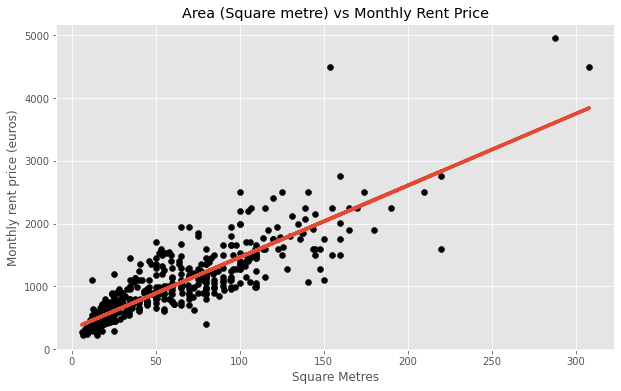

In [72]:
plt.scatter(data["Area"], data["Price"], c = 'k')
plt.plot(data["Area"], ms[0].predict(data["Area"]), linewidth = 3.5)
plt.title("Area (Square metre) vs Monthly Rent Price")
plt.ylabel("Monthly rent price (euros)")
plt.xlabel("Square Metres")

Since certain features already seem to be problematic, it might be better to perform some **Feature Selection** before we proceed with different models. Thus, we will try to do **Forward Selection** in a multilinear regression model to see whether we can create a better model. 

In [73]:
data.columns

Index(['Price', 'Area', 'Number_of_Rooms', 'INW_014_pct', 'INW_1524_pct',
       'INW_2544_pct', 'INW_4564_pct', 'INW_65PL_pct', 'social_benefit_pct',
       'corp_owned_pct', 'P_WE_MIG_A_pct', 'P_NL_ACHTG_pct', 'P_NW_MIG_A_pct',
       'type_apartment', 'type_house', 'zipcode_6216', 'zipcode_6221',
       'zipcode_6224', 'zipcode_6217', 'zipcode_6211', 'zipcode_6214',
       'zipcode_6213', 'zipcode_6227', 'zipcode_6215', 'zipcode_6225',
       'zipcode_6212', 'zipcode_6226', 'zipcode_6219', 'zipcode_6222',
       'zipcode_6229', 'zipcode_6218', 'zipcode_6223', 'zipcode_6228'],
      dtype='object')

### Forward Selection on a multilinear model using 5-Fold Cross Validation

In [74]:
data = data.dropna(subset=['Area']).reset_index(drop = True)
train, val = train_test_split(data, test_size=0.3, random_state=420)

In [75]:

def df_to_dataset(df, predictors, target):
    """Turns a dataframe into an sklearn dataset."""
    X = df[predictors]
    y = df[target]
    return X, y


# Define the list of allowed, possible predictors
possible_predictors = cols

# Code to find the best predictors and their R-squared using forward selection
def find_best_predictors_for_model(regression_model, possible_predictors, data):
    predictor_combinations = [{
        'predictors': [],
        'rsquared': 0
    }]

    for iteration in range(len(possible_predictors)):
        previous_best = predictor_combinations[-1]['predictors']
        allowed_set = list(set(possible_predictors) - set(previous_best))

        scores = {}
        for predictor in allowed_set:
            train_x, train_y = df_to_dataset(train, previous_best + [predictor], 'Price')
            val_x, val_y = df_to_dataset(val, previous_best + [predictor], 'Price')

            regression_model.fit(train_x, train_y)
            scores[predictor] = np.mean(cross_val_score(LinearRegression(fit_intercept=True),pd.concat([train_x,val_x]),pd.concat([train_y,val_y])))
            #scores[predictor] = regression_model.score(val_x, val_y)

        best_allowed_predictor = max(allowed_set, key=lambda predictor: scores[predictor])
        current_best = previous_best + [best_allowed_predictor]
        predictor_combinations.append({
            'predictors': current_best,
            'rsquared': max(scores.values())
        })

    best_combination = predictor_combinations[
        max(range(len(predictor_combinations)), key=lambda x: predictor_combinations[x]['rsquared'])
    ]
    return best_combination

In [76]:
rm = LinearRegression(fit_intercept=True)
find_best_predictors_for_model(rm, cols, data)

{'predictors': ['Area',
  'INW_4564_pct',
  'Number_of_Rooms',
  'type_apartment',
  'corp_owned_pct',
  'zipcode_6213',
  'zipcode_6222',
  'zipcode_6217',
  'zipcode_6211',
  'zipcode_6214',
  'zipcode_6219',
  'zipcode_6229'],
 'rsquared': 0.7826912978133473}

### Linear Regression with Log Transformed Data

The four main assumptions of Linear Regression are:

- Linearity (The relationship between the dependent and independent variables is linear)
- Homoscedasticity (The variance of the residual values is the same)
- Independent Observations
- Normality (The linear regression model requires all variables to be multivariate normal. 

In our case it seems that at least two of the assumptions of Linear Regression, Normality and Homoscedasticity do not hold. In order to try to fix these two assumptions we can work with our best Univariate Linear Regression model, namely the `Price ~ Area` model, which had an $R^{2}$ value of 0.758 .

Text(0, 0.5, 'Frequency')

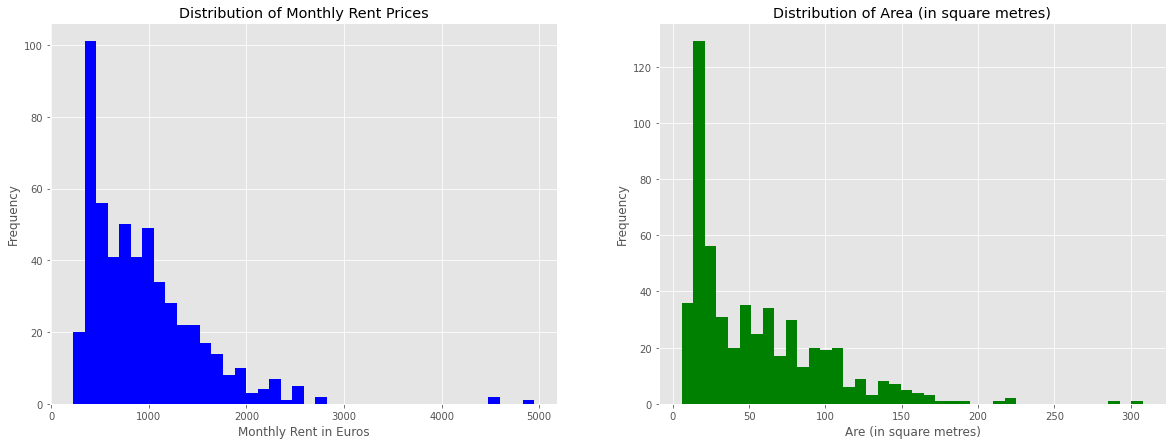

In [77]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,7))
ax1.hist(data["Price"], bins = 40, color = 'b')
ax1.set_title("Distribution of Monthly Rent Prices")
ax1.set_xlabel("Monthly Rent in Euros")
ax1.set_ylabel("Frequency")
ax2.hist(data["Area"], bins = 40, color = 'g')
ax2.set_title("Distribution of Area (in square metres)")
ax2.set_xlabel("Are (in square metres)")
ax2.set_ylabel("Frequency")

We can observe that both our dependent (Price) and independent (Area) variables are right-skewed. This means that there is no chance that any of these distributions is Normal (We don't even have to test it with the Kolmogorov-Smirnov test). After some research, we found out that a nice way to make the data more Gaussian like is to take their log. By taking the log of both the dependent and independent variables we will create a: $$log-log model: log(Y) = a + \beta \cdot log(X) + \epsilon$$

Text(0.5, 1.0, 'Log(Area) vs Log(Price)')

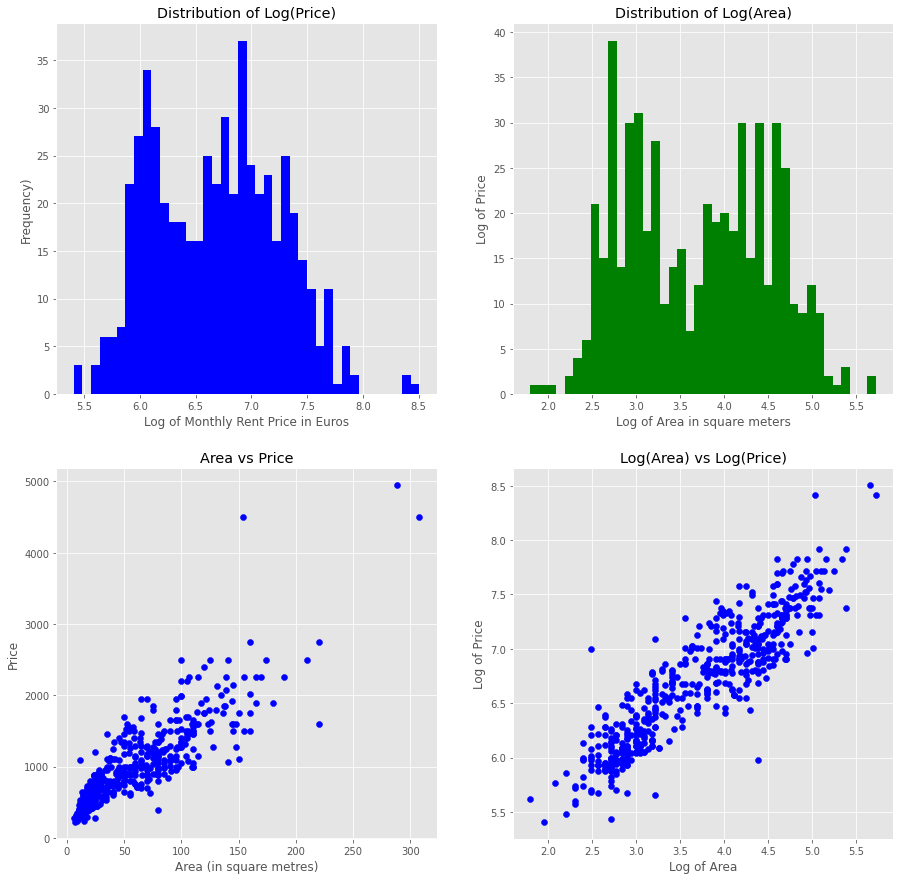

In [78]:
fig, ax = plt.subplots(2,2, figsize = (15,15))
ax[0,0].hist(np.log(data["Price"]), bins =40, color = 'b')
ax[0,0].set_xlabel("Log of Monthly Rent Price in Euros")
ax[0,0].set_ylabel("Frequency)")
ax[0,0].set_title("Distribution of Log(Price)")
ax[0,1].hist(np.log(data["Area"]),bins =40,  color = 'g')
ax[0,1].set_xlabel("Log of Area in square meters")
ax[0,1].set_ylabel("Log of Price")
ax[0,1].set_title("Distribution of Log(Area)")
ax[1,0].scatter(data["Area"], data["Price"], c = 'b')
ax[1,0].set_xlabel("Area (in square metres)")
ax[1,0].set_ylabel("Price")
ax[1,0].set_title("Area vs Price")
ax[1,1].scatter(np.log(data["Area"]), np.log(data["Price"]), c = 'b')
ax[1,1].set_xlabel("Log of Area")
ax[1,1].set_ylabel("Log of Price")
ax[1,1].set_title("Log(Area) vs Log(Price)")


The distribution of the log transformed data looks much more Gaussian like! Moreover, it is very interesting to see that in the bottom right graph the variance of the residual values appears to be the same, which implied that it is Homoscedastic.

We can try to fit a Linear Regression Model on the log transformed data to see whether the model captures better the variability of the data.

In [79]:
area_price = data[["Area", "Price"]]
area_price["Area"] = np.log(area_price["Area"])
area_price["Price"] = np.log(area_price["Price"])

<ipython-input-79-c5f48bab43a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_price["Area"] = np.log(area_price["Area"])
<ipython-input-79-c5f48bab43a4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_price["Price"] = np.log(area_price["Price"])


In [80]:
model = sm.ols('Price ~ Area', data= area_price).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     2393.
Date:                Wed, 24 Mar 2021   Prob (F-statistic):          8.04e-200
Time:                        17:42:49   Log-Likelihood:                0.36038
No. Observations:                 538   AIC:                             3.279
Df Residuals:                     536   BIC:                             11.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3487      0.049     88.857      0.000       4.253       4.445
Area           0.6335      0.013     48.921      0.000       0.608       0.659
==============================================================================
Omnibus:                       24.877   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.490
Skew:                           0.253   Prob(JB):                     6.59e-12
Kurtosis:                       4.429   Cond. No.                         18.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We observe that the $R^2$ value in this log-log model is 0.817! Which means that 81.7% of the variability is explained by the data!

## Conformal prediction

Conformal prediction allows us to find predictive sets with a guaranteed coverage, based on point-estimate models like linear regression. It requires very few assumptions, and can thus also be used with more complex models like ridge regression or boosted models.

In practice, it's a very nice methodology for predictive inference, as we don't really need to know how the model works underneath to obtain statistically sound results. So, we can construct a model which outputs predictive sets with, say 90% guaranteed coverage, and for every input example we will know that the set given by the model has a 90% probability to contain the true target variable value.

The methods used are implemented in our `madness` package; the code is available [here](https://gitlab.com/k-cybulski/dke-data-madness-2021/-/blob/master/madness/conformal.py). In particular, we mainly rely on Papadopoulos et al.[1] and Romano et al.[2] for specifics.

[1] H. Papadopoulos, K. Proedrou, V. Vovk, and A. Gammerman, “Inductive Confidence Machines for Regression,” in Machine Learning: ECML 2002, Berlin, Heidelberg, 2002, pp. 345–356, doi: 10.1007/3-540-36755-1_29.

[2] Y. Romano, E. Patterson, and E. Candes, “Conformalized Quantile Regression,” in Advances in Neural Information Processing Systems 32, H. Wallach, H. Larochelle, A. Beygelzimer, F. d\textquotesingle Alché-Buc, E. Fox, and R. Garnett, Eds. Curran Associates, Inc., 2019, pp. 3543–3553.


### Conformal prediction demonstration

Before we proceed to use conformal prediction on top of a good model which uses multiple features, we will demonstrate how conformal prediction can be used with a single feature linear regression.

Conformal prediction requires the training set to be split into a proper training set for fitting the model and a calibration set.

In [81]:
proper_train, calibration = train_test_split(train, test_size=0.25, random_state=420)

In [82]:
X_proper_train, y_proper_train = df_to_dataset(proper_train, ['Area'], 'Price')
X_calibration, y_calibration = df_to_dataset(calibration, ['Area'], 'Price')

Below we fit a conformal regressor with a significance level 0.1, which means that we expect the resulting predictive sets to cover 90% of test samples.

In [83]:
conformal_model = ConformalResidualRegressor(LinearRegression(), 0.1)
conformal_model.fit(X_proper_train.values, y_proper_train.values, X_calibration.values, y_calibration.values)

So, we have our simple conformal model which predicts price based solely on area. Let's see how the outputs of this model look like on a scatterplot.

In [84]:
X_test, y_test = df_to_dataset(val, ['Area'], 'Price')

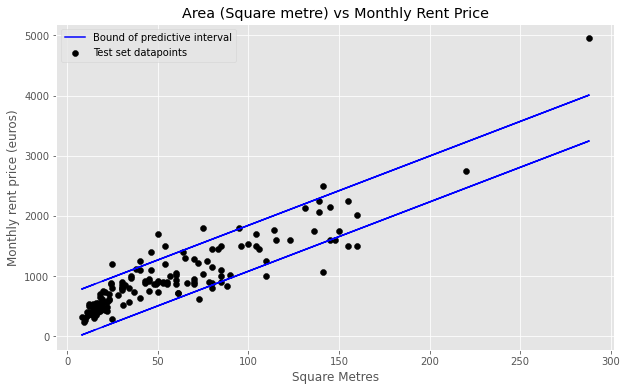

In [85]:
lo, hi = conformal_model.predict(X_test)

plt.scatter(X_test, y_test, c = 'k', label='Test set datapoints')
plt.plot(X_test, lo, linewidth = 1.5, color='blue')
plt.plot(X_test, hi, linewidth = 1.5, color='blue', label='Bound of predictive interval')
plt.title("Area (Square metre) vs Monthly Rent Price")
plt.ylabel("Monthly rent price (euros)")
plt.xlabel("Square Metres")
plt.legend()
plt.show()

Let's now see the total width of the predictive interval. Note that, by default, conformal prediction does not account for heteroskedasticity in the data, and thus the interval has constant length regardless of input features.

In [86]:
# This is the total width of the predictive interval
print("The residual threshold is {:.4f} euro per month, so the total interval width is {:.4f} euro per month.".format(conformal_model._res_buf, conformal_model._res_buf*2))

The residual threshold is 381.5471 euro per month, so the total interval width is 763.0941 euro per month.


So the total width of the predictive interval is 763 euro per month. This is quite good for more pricy apartments, but admittedly this isn't very informative for student-price range apartments.

The constant length of intervals is a problem with basic conformal regression using residuals as a nonconformity score, but we will return to that with a nicer model that accounts for variance.

And now, let's see how close the coverage is to the actual expected coverage (90%).

In [87]:
y_test_reshaped = y_test.values.reshape((-1, 1)) 
print("The empirical coverage is {:.1f}%".format(((y_test_reshaped >= lo) & (y_test_reshaped <= hi)).sum()/(len(y_test_reshaped)) * 100))

The empirical coverage is 88.3%


The empirical coverage on the test set is 88.3%, which is very close to desired 90%!

### Conformal ridge regression

Now let's build a ridge regression model based on the best features we found, and let's see whether the intervals are narrower.

By constructing such a model, we will know how accurately we can predict rent prices (i.e. how wide the expected error is).

In [88]:
best_predictors = ['Area',
  'INW_4564_pct',
  'Number_of_Rooms',
  'type_apartment',
  'corp_owned_pct',
  'zipcode_6213',
  'zipcode_6222',
  'zipcode_6217',
  'zipcode_6211',
  'zipcode_6214',
  'zipcode_6219',
  'zipcode_6229']

In [89]:
X_proper_train, y_proper_train = df_to_dataset(proper_train, best_predictors, 'Price')
X_calibration, y_calibration = df_to_dataset(calibration, best_predictors, 'Price')

We will use a significance level of 0.1, so we expect the predictive intervals to contain 90% of test samples.

In [90]:
conformal_model = ConformalResidualRegressor(RidgeCV(), 0.1)
conformal_model.fit(X_proper_train.values, y_proper_train.values, X_calibration.values, y_calibration.values)

In [91]:
# This is the total width of the predictive interval
print("The residual threshold is {:.4f} euro per month, so the total interval width is {:.4f} euro per month.".format(conformal_model._res_buf, conformal_model._res_buf*2))

The residual threshold is 333.2865 euro per month, so the total interval width is 666.5730 euro per month.


So, we have a total width of 666.6 euro per month, which is narrower by ~97 euro than the simple linear regression we tried before! We will now evaluate what fraction of the actual test samples are covered by the predictive intervals.

In [92]:
X_test, y_test = df_to_dataset(val, best_predictors, 'Price')
lo, hi = conformal_model.predict(X_test.values)

In [93]:
y_test_reshaped = y_test.values.reshape((-1, 1)) 
print("The empirical coverage is {:.1f}%".format(((y_test_reshaped >= lo) & (y_test_reshaped <= hi)).sum()/(len(y_test_reshaped)) * 100))

The empirical coverage is 86.4%


We wanted 90% and got an empirical coverage of 86.4% on the test set. Not ideal, but pretty good.

### Conformalized quantile regression demonstration
As we have shown before, the conformal regression predictive intervals are not adaptive to variance in the data. This is bad for poor students who do care about the few euro difference between one house and another. We will now present conformalized quantile regression [1] on top of a gradient boosting regressor.

[1]Y. Romano, E. Patterson, and E. Candes, “Conformalized Quantile Regression,” in Advances in Neural Information Processing Systems 32, H. Wallach, H. Larochelle, A. Beygelzimer, F. d\textquotesingle Alché-Buc, E. Fox, and R. Garnett, Eds. Curran Associates, Inc., 2019, pp. 3543–3553.


Like before, we will first use a single-feature model to be able to plot nicely how this works.

In [94]:
X_proper_train, y_proper_train = df_to_dataset(proper_train, ['Area'], 'Price')
X_calibration, y_calibration = df_to_dataset(calibration, ['Area'], 'Price')
X_test, y_test = df_to_dataset(val, ['Area'], 'Price')

We will once again use a significance level of 0.1, so expected coverage is 90%.

In [95]:
conformal_model = ConformalizedQuantileRegressor(0.1)
conformal_model.fit(X_proper_train.values, y_proper_train.values, X_calibration.values, y_calibration.values)

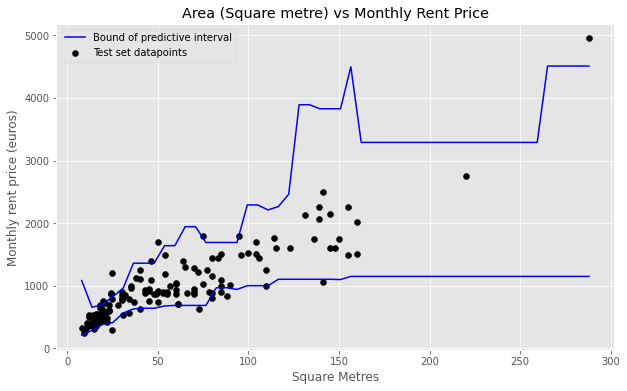

In [96]:
X_line = np.linspace(X_test.min(), X_test.max())

lo, hi = conformal_model.predict(X_line)

plt.scatter(X_test, y_test, c = 'k', label='Test set datapoints')
plt.plot(X_line, lo, linewidth = 1.5, color='blue')
plt.plot(X_line, hi, linewidth = 1.5, color='blue', label='Bound of predictive interval')
plt.title("Area (Square metre) vs Monthly Rent Price")
plt.ylabel("Monthly rent price (euros)")
plt.xlabel("Square Metres")
plt.legend()
plt.show()

As we can see, the predictive interval is now adaptive to variance in the data.

Let's compute some percentiles of interval width.

In [97]:
lo, hi = conformal_model.predict(X_test)
k = hi - lo
print("25th percentile: {} euro per month\n50th percentile: {} euro per month\n75th percentile: {} euro per month".format(*np.quantile(k, [0.25, 0.5, 0.75])))



25th percentile: 396.37649956989276 euro per month
50th percentile: 721.312669551312 euro per month
75th percentile: 994.8148071488038 euro per month


In [98]:
np.quantile(hi - lo, [0.25, 0.5, 0.75])

array([396.37649957, 721.31266955, 994.81480715])

So the median interval width is 721.3 euro per month, so better than 763 for the simple linear model.

Furthermore, for the bottom 25th percentile, it's only a range of 396.4 euro per month. This _could_ be the range of error for a wealthy students!

And now, let's see how close the coverage is to the actual expected coverage (90%).

In [99]:
y_test_reshaped = y_test.values.reshape((-1, 1))
print("The empirical coverage is {:.1f}%".format(((y_test_reshaped >= lo) & (y_test_reshaped <= hi)).sum()/(len(y_test_reshaped)) * 100))

The empirical coverage is 88.9%


The empirical coverage on the test set is 88.9%, which is once again very close to the desired 90%.

### Conformalized quantile regression on good features
Now, to finish off the conformal prediction section, we will use a conformalized quantile regression model trained on the best features we found beforehand.

In [100]:
X_proper_train, y_proper_train = df_to_dataset(proper_train, best_predictors, 'Price')
X_calibration, y_calibration = df_to_dataset(calibration, best_predictors, 'Price')
X_test, y_test = df_to_dataset(val, best_predictors, 'Price')

In [101]:
conformal_model = ConformalizedQuantileRegressor(0.1)
conformal_model.fit(X_proper_train.values, y_proper_train.values, X_calibration.values, y_calibration.values)

In [102]:
lo, hi = conformal_model.predict(X_test)
k = hi - lo
print("25th percentile: {} euro per month\n50th percentile: {} euro per month\n75th percentile: {} euro per month".format(*np.quantile(k, [0.25, 0.5, 0.75])))

25th percentile: 340.91395426085046 euro per month
50th percentile: 559.5749401306305 euro per month
75th percentile: 872.842118671937 euro per month


So, our intervals are narrower than in the simple one-feature predictor! We got 340.9 euro per month intervals for the bottom 25th percentile, which is quite good. This is actually narrow enough to matter for some moderately cheap housing.

In [103]:
y_test_reshaped = y_test.values.reshape((-1, 1))
print("The empirical coverage is {:.1f}%".format(((y_test_reshaped >= lo) & (y_test_reshaped <= hi)).sum()/(len(y_test_reshaped)) * 100))

The empirical coverage is 88.9%


Our intervals obtain an empirical coverage of 88.9% on the test set, which is quite good as well.

So, we can predict the price of monthly rental cost down to adaptive intervals as narrow as 340.9 euro per month with 90% confidence. The gradient boosting model is unfortunately quite difficult to interpret, but if we just want results this is probably the best we've got on this dataset.

## Hypothesis testing
We proposed two hypotheses to test in our project proposal:
 - Are rent prices biased towards migration background?
 - Does age of residents affect rent prices of the neighborhood?
 
We will now tackle them.

To test these hypotheses, we will use the Spearman rank-order correlation coefficient, rather than the more common Pearson correlation coefficient.

[1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html

[2] https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

The reason why we use the Spearman rank instead of the Pearson rank is that the latter assumes the data to be normally distributed and, as we have seen above, this assumption does not hold for our data.

In [104]:
from scipy.stats import spearmanr

### Rent prices and migration background

The population statistics available contain information on two different groups of immigrants: those with western migration background and those with non-western migration background. We will test our hypothesis separately for each of these groups.

We will start by obtaining the Pearson rank for the correlation between the percentage of immigrants with non-western background and the rental price per square meter.

In [105]:
spearmanr(data['P_NW_MIG_A_pct'], data['Price']/data['Area'])

SpearmanrResult(correlation=0.0026066077653472963, pvalue=0.9519013349769525)

According to the Spearman rank, we cannot reject the null hypothesis that there is no correlation between percentage of non-western migrants and price per square meter.

Now, we will continue to test the same hypothesis for immigrants with western background.

In [106]:
spearmanr(data['P_WE_MIG_A_pct'], data['Price']/data['Area'])

SpearmanrResult(correlation=0.12345354959464999, pvalue=0.004133353090269249)

Since the p-value is significant at alpha=0.01, we reject the null hypothesis and conclude that there is a positive correlation between percentage of immigrants with western background and rental price per square meter.

To interpret these results we will draw upon the background knowledge that we have about the city of Maastricht: Maastricht has a [university with over 50 % international students](https://www.maastrichtuniversity.nl/about-um/organisation/facts-figures), many of them European. Therefore, it might be that the group of immigrants with western background has a high overlap with the group of students and that the rental prices might actually be biased towards students. 

To investigate this idea, we will have a look whether there is a correlation between the percentage of residents with western migration background and the percentage of residents between the age of 15 and 24. The latter will be used as an indirect, approximate measure of the percentage of students.

In [107]:
spearmanr(data['P_WE_MIG_A_pct'], data['INW_1524_pct'])

SpearmanrResult(correlation=0.9567126328543176, pvalue=1.6995816490849323e-289)

We can see that indeed there is a positive correlation between those groups. We would like to note that this correlation does not explicitly mean that these groups are exactly the same, just that western migrants live where college-aged people live; as mentioned, we suspect these groups to overlap, though.

There might be different reasons why rental prices might be biased towards students: For example, students might tend to rent rooms instead of self-contained apartements or houses. For rooms, the rental price does not only include the room itself but also access to a kitchen, a bathroom and maybe a living room. Therefore, the price per square metre might be biased. Also, looking at the map we produced in the exploratory data analysis, we can see that the percentage of migrants with non-western migration background is highest in the city centre. The bias in rental prices might reflect a tendency for students to live in the city centre due to proximity to most university buildings, shops, cafes and restaurants. Moreover, districts more distant to the centre are often dominated by single family houses.

### Rent prices and age

In the population statistics, there is information on the percentage of 5 different age groups per 4 digit zip code area:

- 0-14 year
- 15-24 years
- 15-44 years
- 45-64 years
- 65+ years

We will test for each of these age groups, whether there is a correlation between percentage of inhabitants of that age group and rental prices:

In [108]:
# 0-14
spearmanr(data['INW_014_pct'], data['Price']/data['Area'])

SpearmanrResult(correlation=-0.12444184098636502, pvalue=0.0038409354128586346)

In [109]:
# 15-24
spearmanr(data['INW_1524_pct'], data['Price']/data['Area'])

SpearmanrResult(correlation=0.12230116842141539, pvalue=0.004499660676658194)

In [110]:
# 25-44
spearmanr(data['INW_2544_pct'], data['Price']/data['Area'])

SpearmanrResult(correlation=0.14632058428610792, pvalue=0.0006632750462625259)

In [111]:
# 45-64
spearmanr(data['INW_4564_pct'], data['Price']/data['Area'])

SpearmanrResult(correlation=-0.1267493908668744, pvalue=0.0032297761752462283)

In [112]:
# 65+
spearmanr(data['INW_65PL_pct'], data['Price']/data['Area'])

SpearmanrResult(correlation=-0.07850824896725601, pvalue=0.06882618459545928)

As we can see, for almost all of the age groups, the Spearman rank is significant. The Spearman rank for the age group 65+ is the only one with a p-value not significant at alpha=0.01, but it is still relatively close to being significant. If we look at the sign of the Spearman rank for each age group, we can observe the following:

- for the age group 0-14 it is negative, indicating lower rental prices for areas with high percentages of that age group
- for the age group 15-24 it is positive, indicating higher rental prices for areas with high percentages of that age group
- for the age group 25-44 it is positive, indicating higher rental prices for areas with high percentages of that age group
- for the age group 45-64 it is negative, indicating lower rental prices for areas with high percentages of that age group
- (for the age group 65+ the p-value of the coefficient is not significant, however we can see that it is negative)

The fact that the correlation between prices and age 0-14 is negative might indicate, that areas where families live are more cheap (for example, because they are more distal to the centre).

For the age group 25-44 we see a positive correlation. We suspect that, in spite of this being a common parenthood age range, this group is also the people who can afford to live in more expensive flats. As such, we hold that this effect overpowers the effect of families living in cheaper areas.

For the age group 15-24 we can see a positive correlation, giving further evidence that areas in which the percentage of students is high have higher rental prices.

### Hypothesis testing conclusion
We conclude that housing prices are biased towards the demographic age makeup of neighbourhoods.

Furthermore, we found that prices are indeed biased towards western migration background, but not nonwestern migration background.